### DATA LOADING AND INTRODUCTION TO OUR DATA INFORMATION

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")


# Load the data
data = pd.read_csv('hvstat_africa_data_v1.0.csv')
print(f"Dataset shape: {data.shape}")
print(f"Memory usage: {data.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

print(f"\nFirst 5 rows:")
print(data.head())

print(f"\nDataset info:")
print(data.info())

print(f"\nMissing values:")
missing_values = data.isnull().sum()
print(missing_values[missing_values > 0])

print(f"\nBasic statistics:")
print(data.describe())

Dataset shape: (203125, 16)
Memory usage: 99.3 MB

First 5 rows:
         fnid country country_code admin_1 admin_2 product season_name  \
0  AO2008A101  Angola           AO   Bengo    none  Banana        Main   
1  AO2008A101  Angola           AO   Bengo    none  Banana        Main   
2  AO2008A101  Angola           AO   Bengo    none  Banana        Main   
3  AO2008A101  Angola           AO   Bengo    none  Banana        Main   
4  AO2008A101  Angola           AO   Bengo    none  Banana        Main   

   planting_year  planting_month  harvest_year  harvest_month  \
0           2007              10          2008              4   
1           2008              10          2009              4   
2           2014              10          2015              4   
3           2015              10          2016              4   
4           2016              10          2017              4   

  crop_production_system  qc_flag    area  production      yield  
0               All (PS)        

### DATA VISUALIZATION AND INTERPRETATION

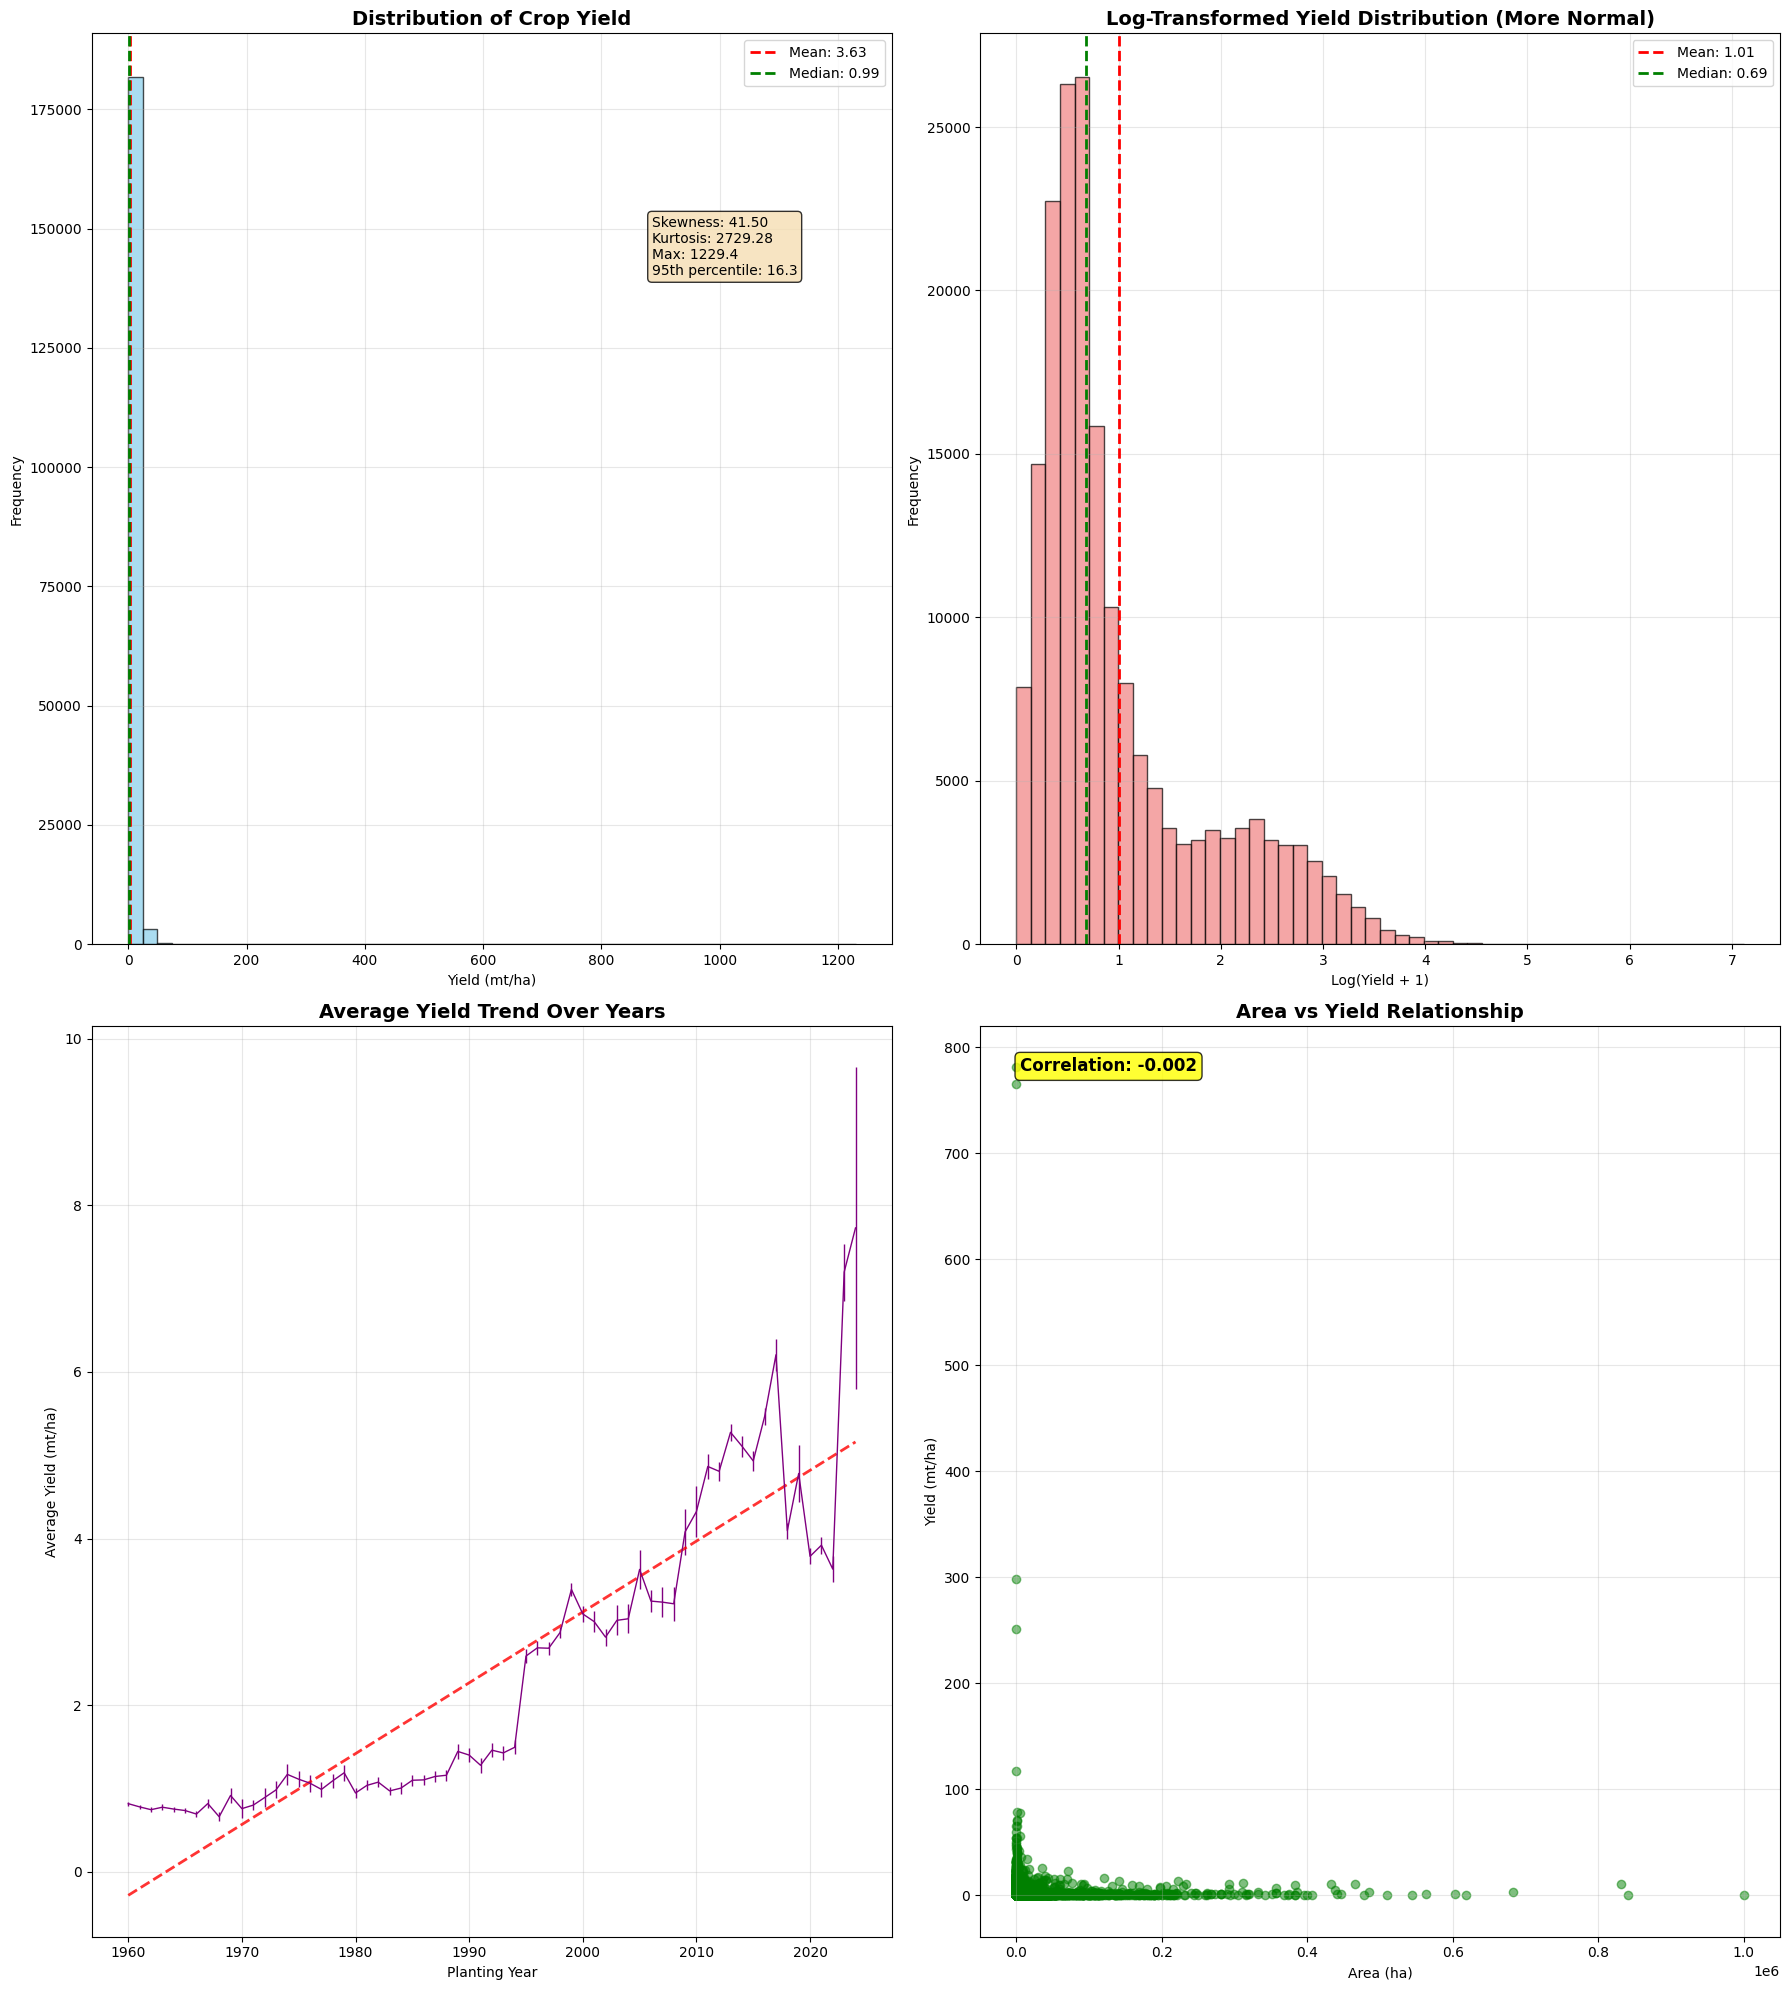

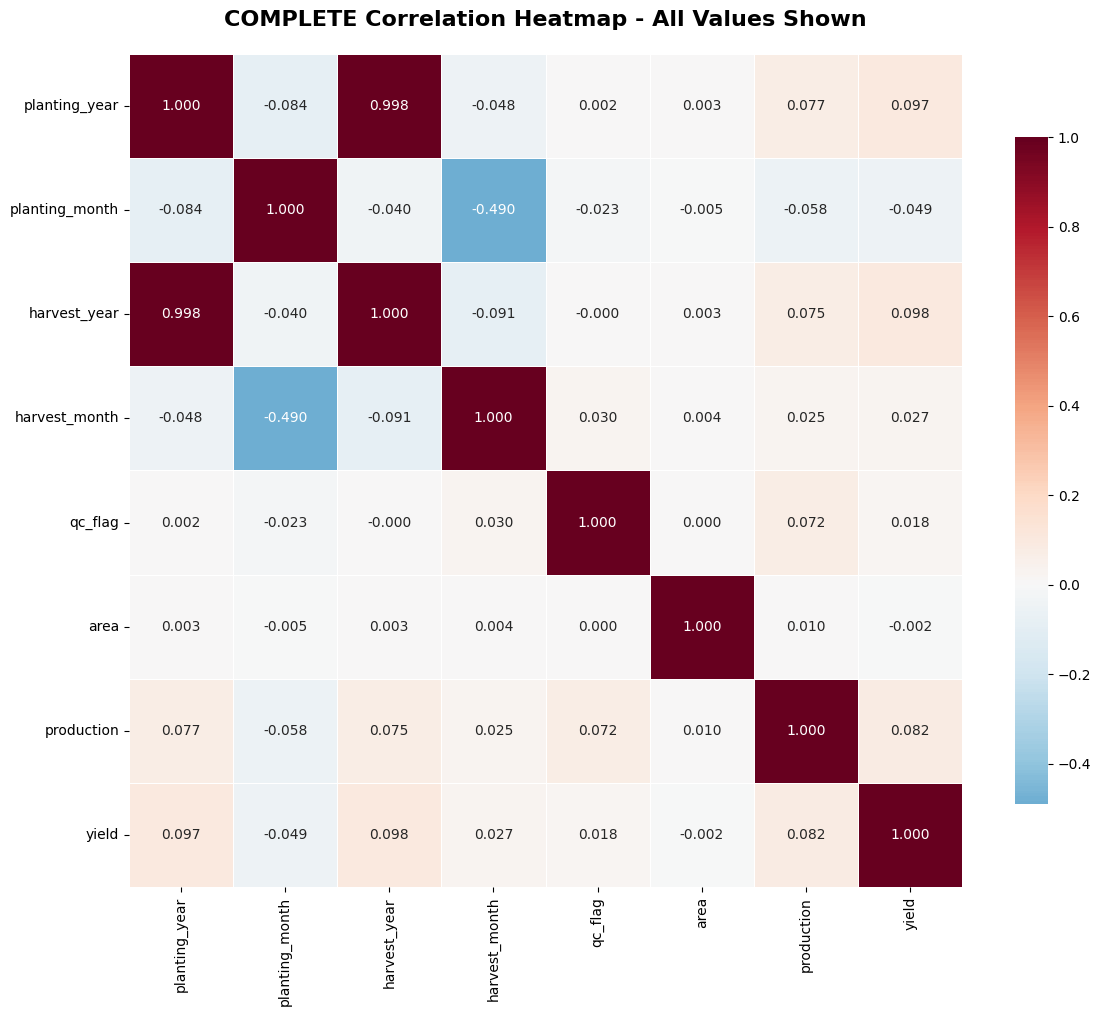

Correlations with Yield (sorted by absolute value):
  harvest_year   :   0.098
  planting_year  :   0.097
  production     :   0.082
  planting_month :  -0.049
  harvest_month  :   0.027
  qc_flag        :   0.018
  area           :  -0.002


In [11]:



fig, axes = plt.subplots(2, 2, figsize=(18, 20))

# 1. Target variable distribution
axes[0,0].hist(data['yield'], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
axes[0,0].axvline(data['yield'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {data["yield"].mean():.2f}')
axes[0,0].axvline(data['yield'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {data["yield"].median():.2f}')
axes[0,0].set_title('Distribution of Crop Yield', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Yield (mt/ha)')
axes[0,0].set_ylabel('Frequency')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

textstr = f'Skewness: {data["yield"].skew():.2f}\nKurtosis: {data["yield"].kurtosis():.2f}\nMax: {data["yield"].max():.1f}\n95th percentile: {data["yield"].quantile(0.95):.1f}'
axes[0,0].text(0.7, 0.8, textstr, transform=axes[0,0].transAxes, fontsize=10,
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# 2. Log-transformed yield (better for modeling)
log_yield = np.log1p(data['yield'])
axes[0,1].hist(log_yield, bins=50, edgecolor='black', alpha=0.7, color='lightcoral')
axes[0,1].axvline(log_yield.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {log_yield.mean():.2f}')
axes[0,1].axvline(log_yield.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {log_yield.median():.2f}')
axes[0,1].set_title('Log-Transformed Yield Distribution (More Normal)', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Log(Yield + 1)')
axes[0,1].set_ylabel('Frequency')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Yield by top crops
# top_crops = data['product'].value_counts().head(8).index
# crop_data = data[data['product'].isin(top_crops)]
# sns.boxplot(data=crop_data, x='product', y='yield', ax=axes[1,0])
# axes[1,0].set_title('Yield Distribution by Top 8 Crops', fontsize=14, fontweight='bold')
# axes[1,0].set_xlabel('Crop Type')
# axes[1,0].set_ylabel('Yield (mt/ha)')
# axes[1,0].tick_params(axis='x', rotation=45)

# # Add sample sizes
# for i, crop in enumerate(top_crops):
#     count = len(crop_data[crop_data['product'] == crop])
#     axes[1,0].text(i, axes[1,0].get_ylim()[1] * 0.9, f'n={count}', ha='center', fontsize=9, color='red', fontweight='bold')

# # 4. Yield by production system
# prod_systems = data['crop_production_system'].dropna().value_counts()
# print(f"\nProduction systems sample sizes:")
# print(prod_systems)

# sns.boxplot(data=data, x='crop_production_system', y='yield', ax=axes[1,1])
# axes[1,1].set_title('Yield by Production System', fontsize=14, fontweight='bold')
# axes[1,1].set_xlabel('Production System')
# axes[1,1].set_ylabel('Yield (mt/ha)')
# axes[1,1].tick_params(axis='x', rotation=45)

#  Time series trend
yearly_stats = data.groupby('planting_year')['yield'].agg(['mean', 'std', 'count']).reset_index()
axes[1,0].errorbar(yearly_stats['planting_year'], yearly_stats['mean'], 
                   yerr=yearly_stats['std']/np.sqrt(yearly_stats['count']), 
                    linewidth=1 , color='purple')
axes[1,0].set_title('Average Yield Trend Over Years', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Planting Year')
axes[1,0].set_ylabel('Average Yield (mt/ha)')
axes[1,0].grid(True, alpha=0.3)

z = np.polyfit(yearly_stats['planting_year'], yearly_stats['mean'], 1)
p = np.poly1d(z)
axes[1,0].plot(yearly_stats['planting_year'], p(yearly_stats['planting_year']), "r--", alpha=0.8, linewidth=2)

#  Area vs Yield relationship
sample_size = min(5000, len(data))
sample_data = data.sample(n=sample_size, random_state=42)
axes[1,1].scatter(sample_data['area'], sample_data['yield'], alpha=0.5, color='green')
axes[1,1].set_title('Area vs Yield Relationship', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Area (ha)')
axes[1,1].set_ylabel('Yield (mt/ha)')
axes[1,1].grid(True, alpha=0.3)

# Add correlation
area_yield_corr = data['area'].corr(data['yield'])
axes[1,1].text(0.05, 0.95, f'Correlation: {area_yield_corr:.3f}', 
               transform=axes[1,1].transAxes, fontsize=12, fontweight='bold',
               bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))

plt.tight_layout()
plt.show()
#  numerical columns for correlation
numerical_cols = ['planting_year', 'planting_month', 'harvest_year', 'harvest_month', 
                  'qc_flag', 'area', 'production', 'yield']

plt.figure(figsize=(12, 10))
correlation_matrix = data[numerical_cols].corr()

sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='RdBu_r', 
            center=0, 
            square=True, 
            fmt='.3f', 
            linewidths=0.5,
            cbar_kws={"shrink": .8})

plt.title('COMPLETE Correlation Heatmap - All Values Shown', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Show correlations with yield specifically
print("Correlations with Yield (sorted by absolute value):")
yield_correlations = correlation_matrix['yield'].sort_values(key=abs, ascending=False)
for feature, corr in yield_correlations.items():
    if feature != 'yield':
        print(f"  {feature:15s}: {corr:7.3f}")

### FEATURE ENGENEERING

In [12]:


#  a copy data for processing
data_processed = data.copy()

# delete rows with missing yield 
data_processed = data_processed.dropna(subset=['yield'])
print(f"Removed {len(data) - len(data_processed)} rows with missing yields")

# Production is calculated as area × yield, so it's data leakage
print(f"Production-Yield correlation: {data_processed['production'].corr(data_processed['yield']):.4f}")

# Harvest dates are future information when predicting yield
leakage_features = ['production', 'harvest_year', 'harvest_month']
data_processed = data_processed.drop(columns=leakage_features, errors='ignore')

# Remove extreme outliers (above 99.5th percentile)
yield_cap = data_processed['yield'].quantile(0.995)
initial_size = len(data_processed)
data_processed = data_processed[data_processed['yield'] <= yield_cap]
print(f"Removed {initial_size - len(data_processed)} extreme outliers (yield > {yield_cap:.1f})")

print("Creating engineered features...")

# Temporal features
data_processed['planting_season'] = data_processed['planting_month'].map({
    12: 'dry', 1: 'dry', 2: 'dry',
    3: 'early_rains', 4: 'early_rains', 5: 'early_rains',
    6: 'peak_rains', 7: 'peak_rains', 8: 'peak_rains',
    9: 'late_rains', 10: 'late_rains', 11: 'late_rains'
})

# Area-based features
data_processed['area_log'] = np.log1p(data_processed['area'])
area_percentiles = data_processed['area'].quantile([0.33, 0.67])
data_processed['farm_size'] = pd.cut(data_processed['area'], 
                                    bins=[0, area_percentiles[0.33], area_percentiles[0.67], np.inf],
                                    labels=['small', 'medium', 'large'])

# Technology era (modern farming techniques)
data_processed['modern_era'] = (data_processed['planting_year'] >= 2010).astype(int)

# Group rare categories to reduce noise
def group_rare_categories(series, min_count=50):
    value_counts = series.value_counts()
    rare_categories = value_counts[value_counts < min_count].index
    return series.replace(rare_categories, 'other')

# Apply to categorical variables
categorical_features = ['product', 'crop_production_system', 'country']
for feature in categorical_features:
    if feature in data_processed.columns:
        original_unique = data_processed[feature].nunique()
        data_processed[feature] = group_rare_categories(data_processed[feature])
        new_unique = data_processed[feature].nunique()
        print(f"  {feature}: {original_unique} → {new_unique} categories")



# hanlding missing values
data_processed['crop_production_system'] = data_processed['crop_production_system'].fillna('unknown')
data_processed['season_name'] = data_processed['season_name'].fillna('unknown')

#  categorical variables
label_encoders = {}
categorical_cols = ['product', 'crop_production_system', 'country', 'season_name', 'planting_season', 'farm_size']

for col in categorical_cols:
    if col in data_processed.columns:
        le = LabelEncoder()
        data_processed[col] = data_processed[col].astype(str)
        data_processed[f'{col}_encoded'] = le.fit_transform(data_processed[col])
        label_encoders[col] = le
        print(f"Encoded {col}: {len(le.classes_)} unique categories")

#  final features for modeling
feature_columns = [
    'planting_year', 'planting_month', 'area', 'area_log', 'qc_flag', 'modern_era',
    'product_encoded', 'crop_production_system_encoded', 'country_encoded',
    'season_name_encoded', 'planting_season_encoded', 'farm_size_encoded'
]

feature_columns = [col for col in feature_columns if col in data_processed.columns]

X = data_processed[feature_columns].copy()
y = data_processed['yield'].copy()

# Handle any remaining missing values
X = X.fillna(X.median())

print(f"Final feature matrix: {X.shape}")
print(f"Target variable range: {y.min():.2f} - {y.max():.2f} mt/ha")

Removed 17695 rows with missing yields
Production-Yield correlation: 0.0819
Removed 928 extreme outliers (yield > 38.4)
Creating engineered features...
  product: 93 → 91 categories
  crop_production_system: 27 → 19 categories
  country: 32 → 32 categories
Encoded product: 91 unique categories
Encoded crop_production_system: 19 unique categories
Encoded country: 32 unique categories
Encoded season_name: 33 unique categories
Encoded planting_season: 4 unique categories
Encoded farm_size: 3 unique categories
Final feature matrix: (184502, 12)
Target variable range: 0.00 - 38.39 mt/ha


### DATA STANDARDIZATION

In [ ]:

# spiliting the data  20% for test and 80 training
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print(f"Training features mean: {X_train_scaled.mean().mean():.6f}")
print(f"Training features std: {X_train_scaled.std().mean():.6f}")


Training set: 147601 samples
Test set: 36901 samples
Training features mean: -0.000000
Training features std: 1.000003


### CUSTOM GRADIENT DESCENT LINEAR REGRESSION

In [14]:


class CustomLinearRegression:
    def __init__(self, learning_rate=0.01, max_iterations=1000, tolerance=1e-6):
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.weights = None
        self.bias = None
        self.train_losses = []
        self.test_losses = []
        self.train_r2_scores = []
        self.test_r2_scores = []
    
    def fit(self, X_train, y_train, X_test=None, y_test=None):
        # Convert to numpy arrays
        if hasattr(X_train, 'values'):
            X_train = X_train.values
        if hasattr(y_train, 'values'):
            y_train = y_train.values
        if X_test is not None and hasattr(X_test, 'values'):
            X_test = X_test.values
        if y_test is not None and hasattr(y_test, 'values'):
            y_test = y_test.values
            
        n_samples, n_features = X_train.shape
        
        self.weights = np.random.normal(0, 0.01, n_features)
        self.bias = 0
        
        prev_loss = float('inf')
        
        for i in range(self.max_iterations):
            y_pred_train = X_train.dot(self.weights) + self.bias
            
            #  training loss (MSE)
            train_loss = np.mean((y_train - y_pred_train) ** 2)
            self.train_losses.append(train_loss)
            
            #  training R²
            train_r2 = r2_score(y_train, y_pred_train)
            self.train_r2_scores.append(train_r2)
            
            if X_test is not None and y_test is not None:
                y_pred_test = X_test.dot(self.weights) + self.bias
                test_loss = np.mean((y_test - y_pred_test) ** 2)
                test_r2 = r2_score(y_test, y_pred_test)
                self.test_losses.append(test_loss)
                self.test_r2_scores.append(test_r2)
            
            #  gradients
            dw = (-2/n_samples) * X_train.T.dot(y_train - y_pred_train)
            db = (-2/n_samples) * np.sum(y_train - y_pred_train)
            
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
            #  convergence
            if abs(prev_loss - train_loss) < self.tolerance:
                print(f"✅ Converged at iteration {i}")
                break
            prev_loss = train_loss
            
            # Progress 
            if i % 200 == 0:
                if X_test is not None:
                    print(f"Iteration {i:4d} | Train Loss: {train_loss:.6f} | Test Loss: {test_loss:.6f} | Test R²: {test_r2:.4f}")
                else:
                    print(f"Iteration {i:4d} | Train Loss: {train_loss:.6f} | Train R²: {train_r2:.4f}")
    
    def predict(self, X):
        if hasattr(X, 'values'):
            X = X.values
        return X.dot(self.weights) + self.bias

#  custom gradient descent model
print("Training Custom Gradient Descent Linear Regression...")
custom_lr = CustomLinearRegression(learning_rate=0.01, max_iterations=2000, tolerance=1e-6)
custom_lr.fit(X_train_scaled, y_train, X_test_scaled, y_test)

Training Custom Gradient Descent Linear Regression...
Iteration    0 | Train Loss: 40.128567 | Test Loss: 39.725931 | Test R²: -0.3518
Iteration  200 | Train Loss: 26.057590 | Test Loss: 25.994488 | Test R²: 0.1155
Iteration  400 | Train Loss: 26.021407 | Test Loss: 25.972998 | Test R²: 0.1162
Iteration  600 | Train Loss: 26.009470 | Test Loss: 25.963880 | Test R²: 0.1165
Iteration  800 | Train Loss: 26.003884 | Test Loss: 25.959359 | Test R²: 0.1166
Iteration 1000 | Train Loss: 26.001197 | Test Loss: 25.957290 | Test R²: 0.1167
Iteration 1200 | Train Loss: 25.999897 | Test Loss: 25.956410 | Test R²: 0.1167
Iteration 1400 | Train Loss: 25.999268 | Test Loss: 25.956076 | Test R²: 0.1168
Iteration 1600 | Train Loss: 25.998963 | Test Loss: 25.955980 | Test R²: 0.1168
✅ Converged at iteration 1611


### MODELS COMPARISON

In [15]:

# Initialize models
models = {
    'Custom Linear Regression': custom_lr,
    'Scikit-Learn Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42, max_depth=10),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
}

# Train scikit-learn models
print("Training scikit-learn models...")
for name, model in models.items():
    if name != 'Custom Linear Regression':
        model.fit(X_train_scaled, y_train)
        print(f"✅ {name} trained")

# Make predictions and evaluate
results = {}
predictions = {}

for name, model in models.items():
    print(f"\nEvaluating {name}...")
    
    #  predictions
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)
    
    # Store predictions for plotting
    predictions[name] = {'train': y_pred_train, 'test': y_pred_test}
    
    # find metrics
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    
    results[name] = {
        'Train R²': train_r2,
        'Test R²': test_r2,
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse,
        'Train MAE': train_mae,
        'Test MAE': test_mae,
        'Overfitting': train_r2 - test_r2
    }
    
    print(f"  Train R²: {train_r2:.4f}")
    print(f"  Test R²:  {test_r2:.4f}")
    print(f"  Test RMSE: {test_rmse:.4f}")
    print(f"  Test MAE: {test_mae:.4f}")

Training scikit-learn models...
✅ Scikit-Learn Linear Regression trained
✅ Decision Tree trained
✅ Random Forest trained

Evaluating Custom Linear Regression...
  Train R²: 0.1264
  Test R²:  0.1168
  Test RMSE: 5.0947
  Test MAE: 3.2601

Evaluating Scikit-Learn Linear Regression...
  Train R²: 0.1264
  Test R²:  0.1168
  Test RMSE: 5.0947
  Test MAE: 3.2599

Evaluating Decision Tree...
  Train R²: 0.7382
  Test R²:  0.7240
  Test RMSE: 2.8482
  Test MAE: 1.3706

Evaluating Random Forest...
  Train R²: 0.7877
  Test R²:  0.7721
  Test RMSE: 2.5879
  Test MAE: 1.2426


### VISUALISING RESULTS


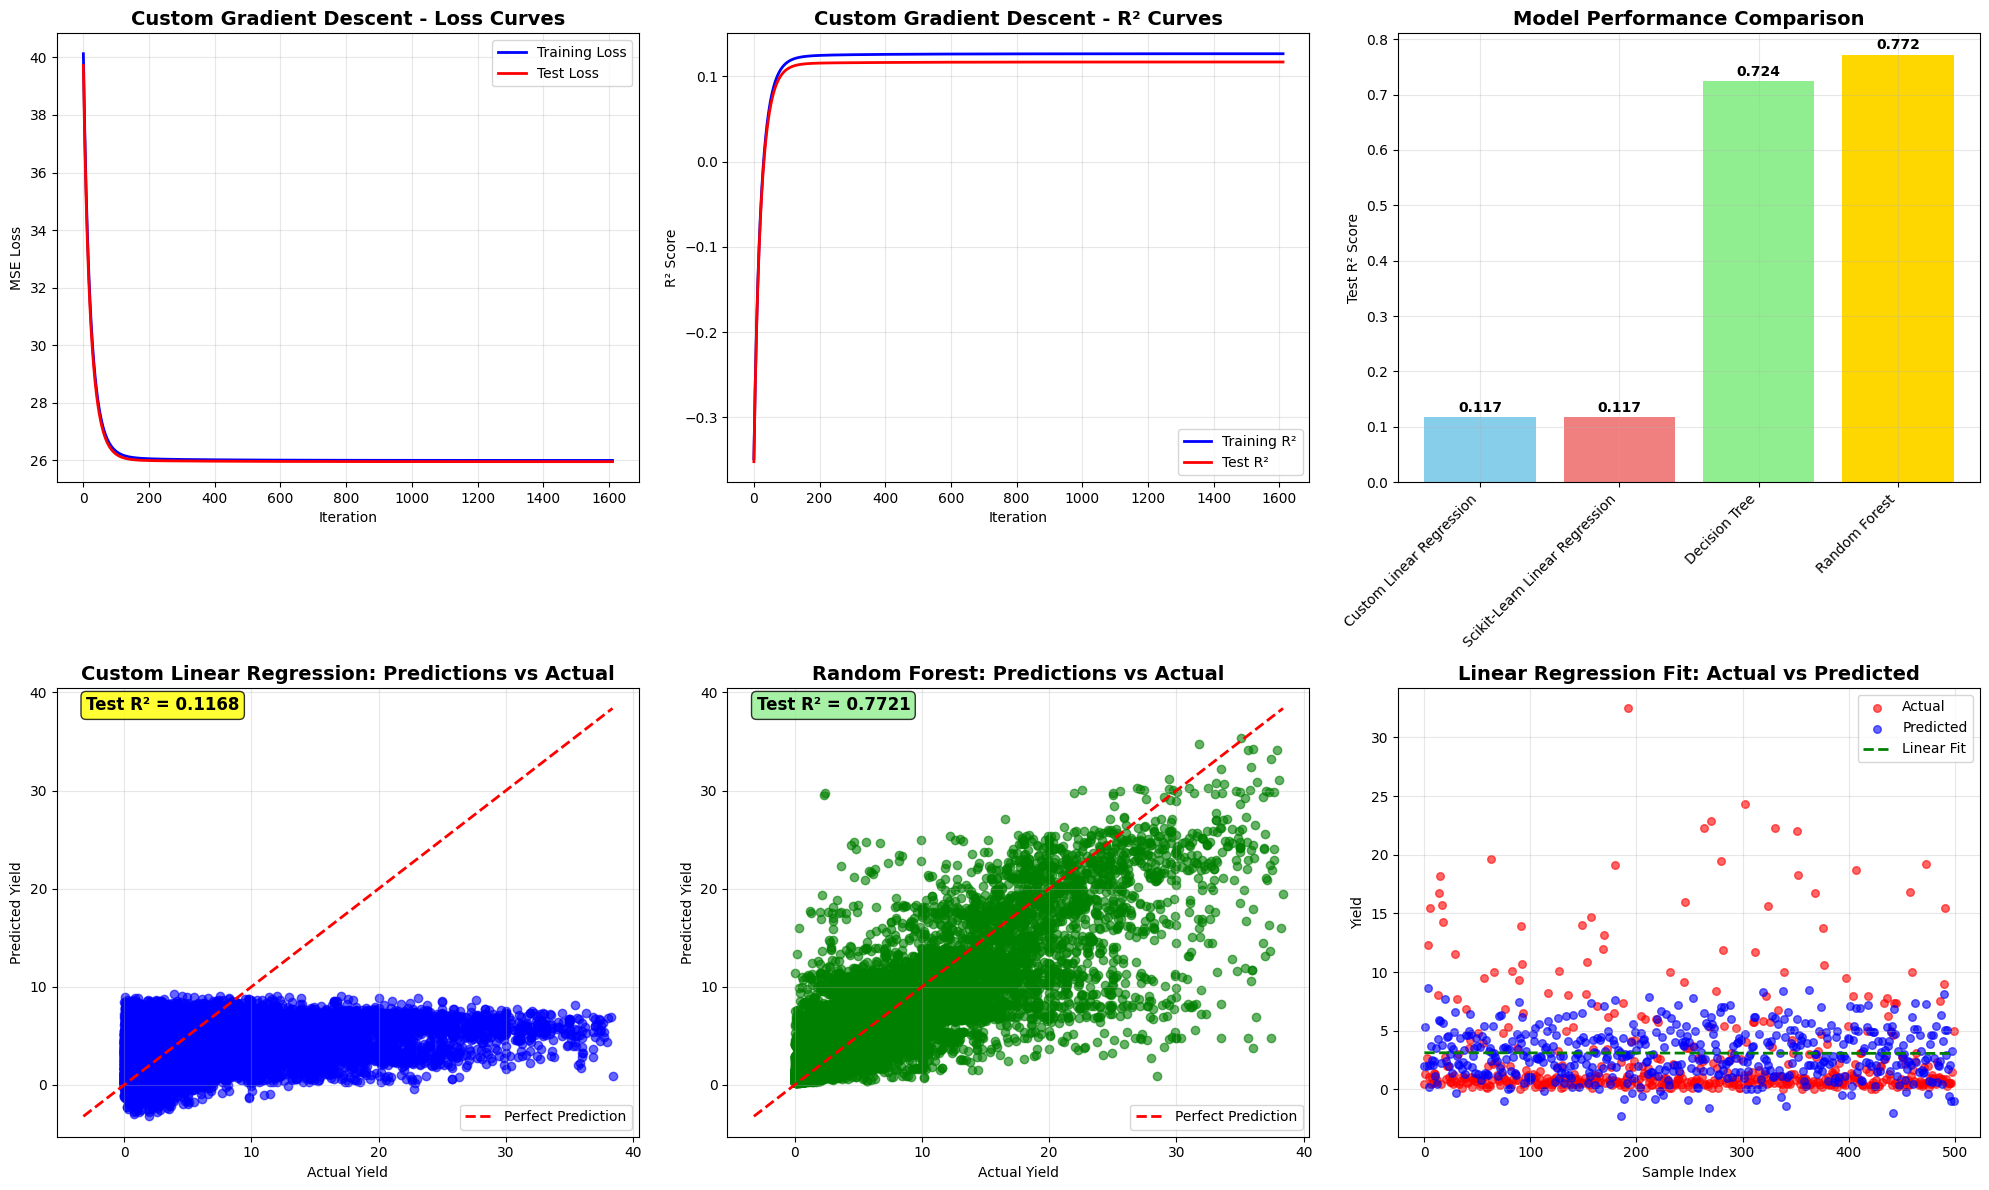

In [16]:


fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Loss curves for custom gradient descent
axes[0,0].plot(custom_lr.train_losses, label='Training Loss', color='blue', linewidth=2)
axes[0,0].plot(custom_lr.test_losses, label='Test Loss', color='red', linewidth=2)
axes[0,0].set_xlabel('Iteration')
axes[0,0].set_ylabel('MSE Loss')
axes[0,0].set_title('Custom Gradient Descent - Loss Curves', fontsize=14, fontweight='bold')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

#  R² curves for custom gradient descent
axes[0,1].plot(custom_lr.train_r2_scores, label='Training R²', color='blue', linewidth=2)
axes[0,1].plot(custom_lr.test_r2_scores, label='Test R²', color='red', linewidth=2)
axes[0,1].set_xlabel('Iteration')
axes[0,1].set_ylabel('R² Score')
axes[0,1].set_title('Custom Gradient Descent - R² Curves', fontsize=14, fontweight='bold')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

#  Model comparison bar chart
results_df = pd.DataFrame(results).T
test_r2_scores = results_df['Test R²']
axes[0,2].bar(range(len(test_r2_scores)), test_r2_scores.values, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
axes[0,2].set_xticks(range(len(test_r2_scores)))
axes[0,2].set_xticklabels(test_r2_scores.index, rotation=45, ha='right')
axes[0,2].set_ylabel('Test R² Score')
axes[0,2].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[0,2].grid(True, alpha=0.3)

for i, v in enumerate(test_r2_scores.values):
    axes[0,2].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

#  Predictions vs Actual - Custom Linear Regression
axes[1,0].scatter(y_test, predictions['Custom Linear Regression']['test'], alpha=0.6, color='blue')
min_val = min(y_test.min(), predictions['Custom Linear Regression']['test'].min())
max_val = max(y_test.max(), predictions['Custom Linear Regression']['test'].max())
axes[1,0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[1,0].set_xlabel('Actual Yield')
axes[1,0].set_ylabel('Predicted Yield')
axes[1,0].set_title('Custom Linear Regression: Predictions vs Actual', fontsize=14, fontweight='bold')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

test_r2_custom = results['Custom Linear Regression']['Test R²']
axes[1,0].text(0.05, 0.95, f'Test R² = {test_r2_custom:.4f}', transform=axes[1,0].transAxes, 
               fontsize=12, fontweight='bold', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))

#  Predictions vs Actual - Best Performing Model
best_model_name = results_df['Test R²'].idxmax()
best_predictions = predictions[best_model_name]['test']

axes[1,1].scatter(y_test, best_predictions, alpha=0.6, color='green')
axes[1,1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[1,1].set_xlabel('Actual Yield')
axes[1,1].set_ylabel('Predicted Yield')
axes[1,1].set_title(f'{best_model_name}: Predictions vs Actual', fontsize=14, fontweight='bold')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

best_r2 = results[best_model_name]['Test R²']
axes[1,1].text(0.05, 0.95, f'Test R² = {best_r2:.4f}', transform=axes[1,1].transAxes, 
               fontsize=12, fontweight='bold', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

# Before and After Linear Regression Line
# Show data with and without the linear fit
sample_indices = np.random.choice(len(y_test), size=min(500, len(y_test)), replace=False)
y_test_sample = y_test.iloc[sample_indices]
y_pred_sample = predictions['Custom Linear Regression']['test'][sample_indices]

# Before (just scattered data)
axes[1,2].scatter(range(len(y_test_sample)), y_test_sample, alpha=0.6, color='red', label='Actual', s=30)
axes[1,2].scatter(range(len(y_test_sample)), y_pred_sample, alpha=0.6, color='blue', label='Predicted', s=30)

z = np.polyfit(range(len(y_test_sample)), y_pred_sample, 1)
p = np.poly1d(z)
axes[1,2].plot(range(len(y_test_sample)), p(range(len(y_test_sample))), "g--", linewidth=2, label='Linear Fit')

axes[1,2].set_xlabel('Sample Index')
axes[1,2].set_ylabel('Yield')
axes[1,2].set_title('Linear Regression Fit: Actual vs Predicted', fontsize=14, fontweight='bold')
axes[1,2].legend()
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### From above figs we can see the best model is by ooking the ggrpagh the rpedicton aremore likely close to the lineof actual data: Random Forest 

### SAVE BEST MODEL AND CREATE PREDICTION FUNCTION

In [19]:


# Find the best model based on Test R²
best_model_name = results_df['Test R²'].idxmax()
best_model = models[best_model_name]

print(f"Best performing model: {best_model_name}")
print(f"Test R² Score: {results[best_model_name]['Test R²']:.4f}")

# Save the best model, scaler, and encoders
import os
model_dir = 'saved_models'
os.makedirs(model_dir, exist_ok=True)

# Save model
joblib.dump(best_model, f'{model_dir}/best_crop_yield_model.pkl')
print(f" Best model saved as: {model_dir}/best_crop_yield_model.pkl")

joblib.dump(scaler, f'{model_dir}/scaler.pkl')
joblib.dump(label_encoders, f'{model_dir}/label_encoders.pkl')
joblib.dump(feature_columns, f'{model_dir}/feature_columns.pkl')

# Save model metadata
model_metadata = {
    'best_model_name': best_model_name,
    'test_r2_score': results[best_model_name]['Test R²'],
    'test_rmse': results[best_model_name]['Test RMSE'],
    'test_mae': results[best_model_name]['Test MAE'],
    'feature_columns': feature_columns,
    'model_performance': results
}

joblib.dump(model_metadata, f'{model_dir}/model_metadata.pkl')


def predict_crop_yield(planting_year, planting_month, area, product, 
                      crop_production_system, country, season_name='unknown', qc_flag=1):
    """
    Predict crop yield based on input parameters
    
    Args:
        planting_year (int): Year of planting (e.g., 2020)
        planting_month (int): Month of planting (1-12)
        area (float): Area in hectares
        product (str): Crop type (e.g., 'maize', 'wheat', 'rice')
        crop_production_system (str): Production system (e.g., 'rainfed', 'irrigated')
        country (str): Country name
        season_name (str): Season name (optional)
        qc_flag (int): Quality control flag (optional, default=1)
    
    Returns:
        dict: Prediction result with yield and confidence info
    """
    try:
        # Load saved components
        model = joblib.load(f'{model_dir}/best_crop_yield_model.pkl')
        scaler = joblib.load(f'{model_dir}/scaler.pkl')
        encoders = joblib.load(f'{model_dir}/label_encoders.pkl')
        feature_cols = joblib.load(f'{model_dir}/feature_columns.pkl')
        
        # Create input data
        input_data = pd.DataFrame({
            'planting_year': [planting_year],
            'planting_month': [planting_month],
            'area': [area],
            'area_log': [np.log1p(area)],
            'qc_flag': [qc_flag],
            'modern_era': [1 if planting_year >= 2010 else 0],
            'product': [product.lower()],
            'crop_production_system': [crop_production_system.lower()],
            'country': [country.lower()],
            'season_name': [season_name.lower()]
        })
        
        # Create planting season
        season_map = {
            12: 'dry', 1: 'dry', 2: 'dry',
            3: 'early_rains', 4: 'early_rains', 5: 'early_rains',
            6: 'peak_rains', 7: 'peak_rains', 8: 'peak_rains',
            9: 'late_rains', 10: 'late_rains', 11: 'late_rains'
        }
        input_data['planting_season'] = season_map.get(planting_month, 'unknown')
        
        # Create farm size
        if area <= 2.0:
            farm_size = 'small'
        elif area <= 10.0:
            farm_size = 'medium'
        else:
            farm_size = 'large'
        input_data['farm_size'] = farm_size
        
        # Encode categorical variables
        for col in ['product', 'crop_production_system', 'country', 'season_name', 'planting_season', 'farm_size']:
            if col in encoders:
                try:
                    # Handle unknown categories
                    if input_data[col].iloc[0] in encoders[col].classes_:
                        input_data[f'{col}_encoded'] = encoders[col].transform(input_data[col])
                    else:
                        # use 'other' category if available, otherwise use most common class
                        if 'other' in encoders[col].classes_:
                            input_data[f'{col}_encoded'] = encoders[col].transform(['other'])
                        else:
                            input_data[f'{col}_encoded'] = [0]  # use first class as default
                except:
                    input_data[f'{col}_encoded'] = [0]
        
        # select features and ensure order matches training
        X_input = input_data[feature_cols].fillna(0)
        
        # Scale features
        X_input_scaled = scaler.transform(X_input)
        
        # Make prediction
        yield_prediction = model.predict(X_input_scaled)[0]
        
        # Calculate confidence based on training data statistics
        confidence = "Medium"  # Simplified confidence calculation
        
        return {
            'success': True,
            'predicted_yield': round(float(yield_prediction), 3),
            'unit': 'mt/ha',
            'confidence': confidence,
            'input_summary': {
                'crop': product,
                'area': area,
                'country': country,
                'planting_year': planting_year,
                'planting_month': planting_month
            }
        }
        
    except Exception as e:
        return {
            'success': False,
            'error': str(e),
            'predicted_yield': None
        }

# Test the prediction function
print("Testing prediction function...")
test_prediction = predict_crop_yield(
    planting_year=2022,
    planting_month=4,
    area=5.0,
    product='maize',
    crop_production_system='rainfed',
    country='kenya'
)

print(f"Test prediction result: {test_prediction}")


Best performing model: Random Forest
Test R² Score: 0.7721
 Best model saved as: saved_models/best_crop_yield_model.pkl
Testing prediction function...
Test prediction result: {'success': True, 'predicted_yield': 5.269, 'unit': 'mt/ha', 'confidence': 'Medium', 'input_summary': {'crop': 'maize', 'area': 5.0, 'country': 'kenya', 'planting_year': 2022, 'planting_month': 4}}
